In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import os

In [2]:
xray_data = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')
num_obs = len(xray_data)
print('Number of observations:',num_obs)
xray_data.head()

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
from glob import glob

my_glob = glob('/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/*.png')
print('Number of images:', len(my_glob))


Number of images: 112120


In [4]:
# Map the image paths onto xray_data
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)
xray_data.shape

(112120, 13)

In [5]:
dropLabels = ['Image Index', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
xray_data.drop(columns = dropLabels, inplace = True)
xray_data.shape

(112120, 3)

In [6]:
xray_data.head()

,Finding Labels,Patient ID,full_path
0,Cardiomegaly,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
1,Cardiomegaly|Emphysema,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
2,Cardiomegaly|Effusion,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
3,No Finding,2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
4,Hernia,3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...


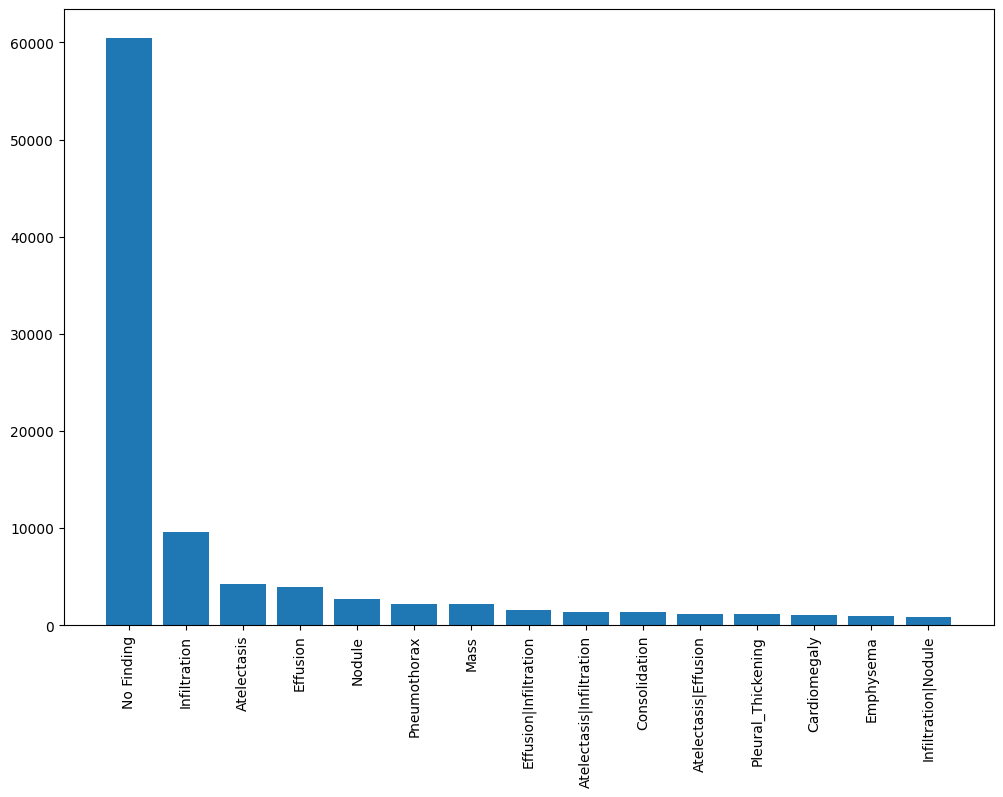

In [7]:
label_counts = xray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
xray_data.head()

,Finding Labels,Patient ID,full_path
0,Cardiomegaly,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
1,Cardiomegaly|Emphysema,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
2,Cardiomegaly|Effusion,1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
3,No Finding,2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...
4,Hernia,3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...


In [9]:
xray_data['Finding Labels'] = xray_data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_data[c_label] = xray_data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_data.shape

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


(112120, 17)

In [10]:
# keep at least 1000 cases
MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if xray_data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(xray_data[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 11535), ('Cardiomegaly', 2772), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13307), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19870), ('Mass', 5746), ('Nodule', 6323), ('Pleural_Thickening', 3385), ('Pneumonia', 1353), ('Pneumothorax', 5298)]


In [11]:
# drop up to 10 rows where 'No Finding' equals 1
#to_drop = xray_data[xray_data['No Finding'] == 1].index[:18596]
#xray_data = xray_data.drop(to_drop)

# print the number of rows in the resulting DataFrame
#print(xray_data.shape[0])

In [12]:
hernia_copy=xray_data

In [13]:
"""# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = xray_data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
xray_data = xray_data.sample(50000, weights=sample_weights)

label_counts = xray_data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)"""

"# since the dataset is very unbiased, we can resample it to be a more reasonable collection\n# weight is 0.1 + number of findings\nsample_weights = xray_data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2\nsample_weights /= sample_weights.sum()\nxray_data = xray_data.sample(50000, weights=sample_weights)\n\nlabel_counts = xray_data['Finding Labels'].value_counts()[:15]\nfig, ax1 = plt.subplots(1,1,figsize = (12, 8))\nax1.bar(np.arange(len(label_counts))+0.5, label_counts)\nax1.set_xticks(np.arange(len(label_counts))+0.5)\n_ = ax1.set_xticklabels(label_counts.index, rotation = 90)"

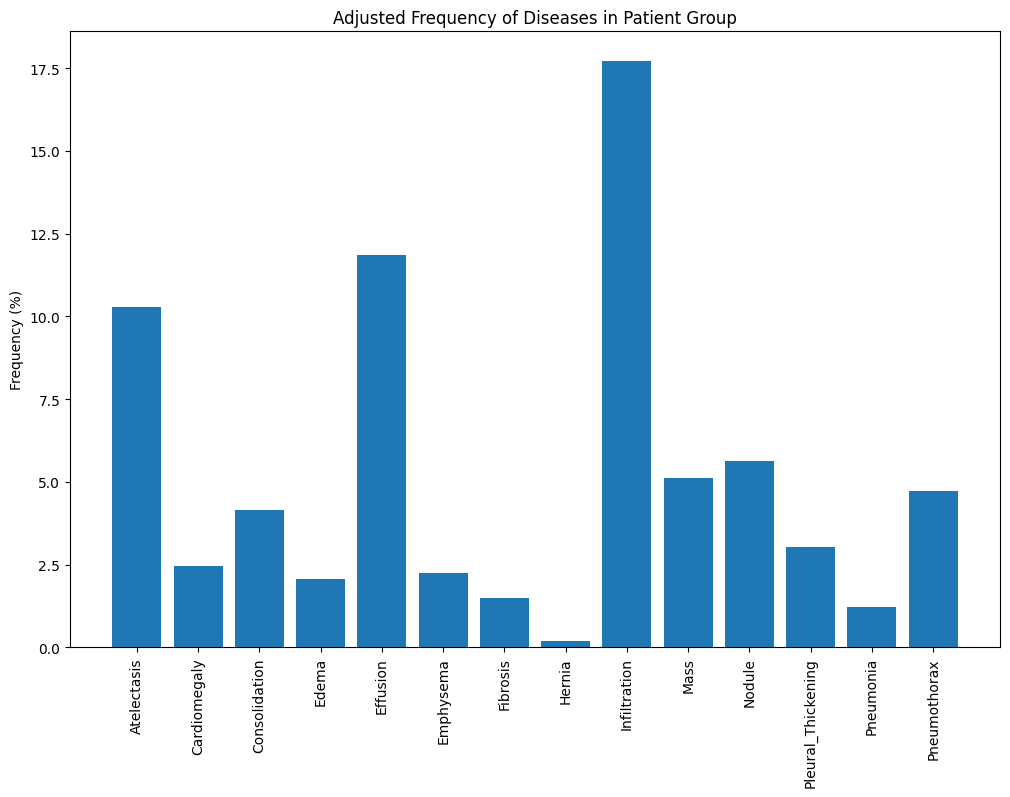

In [14]:
label_counts = 100*np.mean(xray_data[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts) 
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [15]:
# Clean Labels (14) [('Atelectasis', 10709), ('Cardiomegaly', 2565), ('Consolidation', 4409), ('Edema', 2185), ('Effusion', 12407), ('Emphysema', 2349), ('Fibrosis', 1544), ('Hernia', 215), ('Infiltration', 18066), ('Mass', 5345), ('Nodule', 5816), ('Pleural_Thickening', 3157), ('Pneumonia', 1378), ('Pneumothorax', 4904)]


MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if xray_data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(xray_data[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 11535), ('Cardiomegaly', 2772), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13307), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19870), ('Mass', 5746), ('Nodule', 6323), ('Pleural_Thickening', 3385), ('Pneumonia', 1353), ('Pneumothorax', 5298)]


In [16]:
xray_data.shape

(112120, 17)

In [17]:
#xray_data.to_csv('NIH/resampled_data.csv', index=False)
#xray_data.shape

In [18]:
df= xray_data

# Check for duplicates in the 'Patient ID' column
print(any(df['Patient ID'].duplicated()))

# Check for missing values in the 'Patient ID' column
print(df['Patient ID'].isna().sum())

True
0


In [19]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets based on the 'id' column
train_ids, test_ids = train_test_split(df['Patient ID'].unique(), test_size=0.1, random_state=2023)

# Split the train data further into train and validation sets
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=2023)

# Create train, validation, and test dataframes based on the split ids
train_df = df[df['Patient ID'].isin(train_ids)]
val_df = df[df['Patient ID'].isin(val_ids)]
test_df = df[df['Patient ID'].isin(test_ids)]
print(df.shape[0], train_df.shape[0], val_df.shape[0], test_df.shape[0])

112120 90426 9672 12022


In [20]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 
    return leakage


In [21]:
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(train_df, val_df, 'Patient ID')
check_for_leakage(val_df, test_df, 'Patient ID')

False

In [22]:
# print the number of rows in each set
print(f'Train set: {train_df.shape[0]} rows')
print(f'Validation set: {val_df.shape[0]} rows')
print(f'Test set: {test_df.shape[0]} rows')

Train set: 90426 rows
Validation set: 9672 rows
Test set: 12022 rows


In [23]:
# print the number of rows in each set
print('Train set:', train_df['Patient ID'].nunique())
print('Validation set:', val_df['Patient ID'].nunique())
print('Test set:', test_df['Patient ID'].nunique())

Train set: 24951
Validation set: 2773
Test set: 3081


In [24]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 90426 vald: 9672 test: 12022


In [25]:
"""
train_df.to_csv('model/train.csv', index=False)
test_df.to_csv('model/test.csv', index=False)
val_df.to_csv('model/validation.csv', index=False)"""

"\ntrain_df.to_csv('model/train.csv', index=False)\ntest_df.to_csv('model/test.csv', index=False)\nval_df.to_csv('model/validation.csv', index=False)"

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model

from keras.optimizers import Adam
from keras.optimizers import AdamW
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Import Densenet from Keras
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")


2024-07-28 08:50:36.804582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 08:50:36.804688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 08:50:37.103209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [27]:
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
          'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass','Hernia']


In [28]:
"""train_df=pd.read_csv('model/train.csv')
test_df=pd.read_csv('model/test.csv')
val_df=pd.read_csv('model/validation.csv')"""

"train_df=pd.read_csv('model/train.csv')\ntest_df=pd.read_csv('model/test.csv')\nval_df=pd.read_csv('model/validation.csv')"

In [29]:
print('train', train_df.shape[0],'vald:',val_df.shape[0], 'test:', test_df.shape[0])

train 90426 vald: 9672 test: 12022


In [30]:
# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img


horizontal_flip=True, 
    vertical_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.1,
    channel_shift_range=20,
    brightness_range=[0.2, 1],
    rotation_range=10, 
    shear_range=0.1,
    fill_mode='reflect',
    zoom_range=0.1,    

In [31]:
# Define the data generators for training, validation, and testing
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 90426 validated image filenames.


In [32]:
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64
)

Found 9672 validated image filenames.


In [33]:
"""test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=12022        
)

x_test, y_test = next(test_generator)"""

"test_generator = ImageDataGenerator(\n    preprocessing_function=preprocess_image\n).flow_from_dataframe(\n    dataframe=test_df,\n    directory=None,\n    x_col='full_path',\n    y_col=labels,\n    target_size=(224, 224),\n    color_mode='rgb',\n    class_mode='raw',\n    batch_size=12022        \n)\n\nx_test, y_test = next(test_generator)"

In [34]:
"""
eval_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=64   
)
"""

"\neval_generator = ImageDataGenerator(\n    preprocessing_function=preprocess_image\n).flow_from_dataframe(\n    dataframe=test_df,\n    directory=None,\n    x_col='full_path',\n    y_col=labels,\n    target_size=(224, 224),\n    color_mode='rgb',\n    class_mode='raw',\n    batch_size=64   \n)\n"

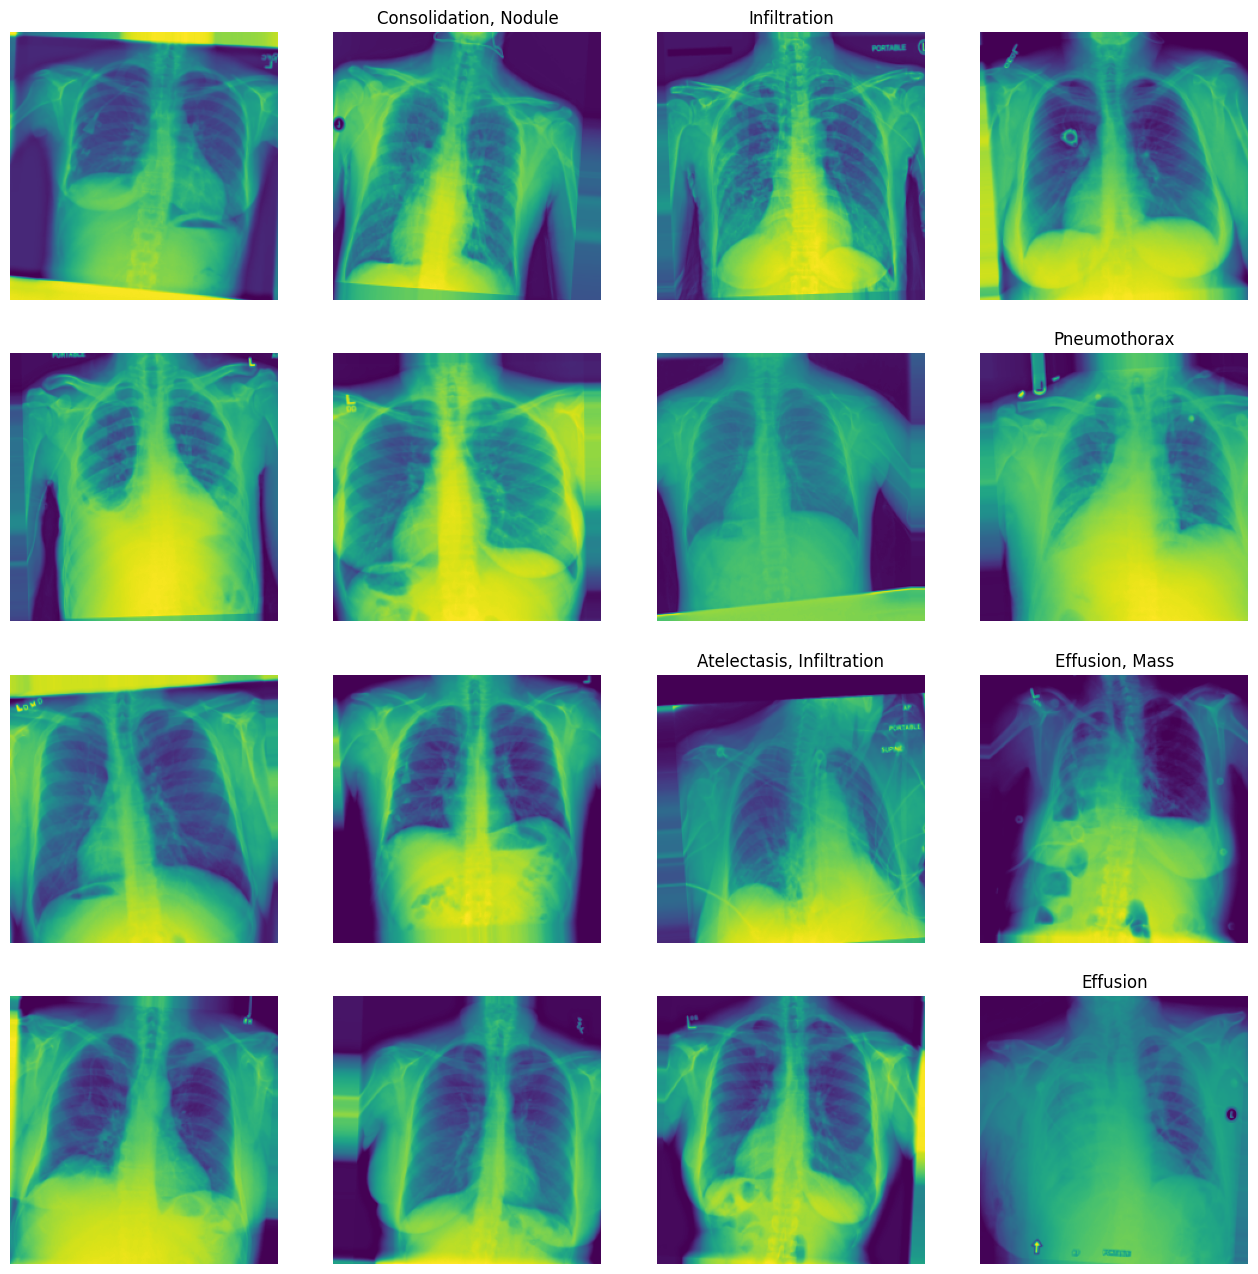

In [35]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [36]:
from keras.applications import EfficientNetV2S

def build_model():
    # Load the pre-trained DenseNet121 model
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add new trainable layers on top of the pre-trained model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    preds = Dense(len(labels), activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=preds)
    # Create an Adam optimizer with weight decay
    optimizer = AdamW(learning_rate=1e-4)
    model.compile(optimizer=optimizer ,loss='binary_crossentropy',metrics=['binary_accuracy']) 
    print(model.summary())
    return model
    #model.summary()

In [37]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [38]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()
#multi_gpu_model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,349,294 (77.63 MB)

 Trainable params: 20,195,422 (77.04 MB)

 Non-trainable params: 153,872 (601.06 KB)

None


In [39]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = 'model/EfficientNetV2S.keras'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint(checkpoint_path, verbose=0, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')


In [40]:
# os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

In [41]:
# Train the model using the generator
history = multi_gpu_model.fit(
    train_generator,
    epochs=20,
#     steps_per_epoch=100,
    callbacks=[anne, checkpoint, early_stopping],

    validation_data=val_generator,
)

Epoch 1/20


2024-07-28 08:57:01.946615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_3276/cond/StatefulPartitionedCall/functional_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 2400s 1s/step - binary_accuracy: 0.9266 - loss: 0.2287 - val_binary_accuracy: 0.9494 - val_loss: 0.1627 - learning_rate: 1.0000e-04
Epoch 2/20
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1607s 1s/step - binary_accuracy: 0.9486 - loss: 0.1582 - val_binary_accuracy: 0.9505 - val_loss: 0.1518 - learning_rate: 1.0000e-04
Epoch 3/20
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1602s 1s/step - binary_accuracy: 0.9493 - loss: 0.1513 - val_binary_accuracy: 0.9504 - val_loss: 0.1489 - learning_rate: 1.0000e-04
Epoch 4/20
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1586s 1s/step - binary_accuracy: 0.9501 - loss: 0.1471 - val_binary_accuracy: 0.9507 - val_loss: 0.1474 - learning_rate: 1.0000e-04
Epoch 5/20
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1640s 1s/step - binary_accuracy: 0.9504 - loss: 0.1444 - val_binary_accuracy: 0.9501 - val_loss: 0.1468 - learning_rate: 1.0000e-04
Epoch 6/20
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1610s 1s/step - binary_accuracy: 0.9505 - loss: 0.1427 - val_binary_accuracy: 0.9506 - val_loss: 0.

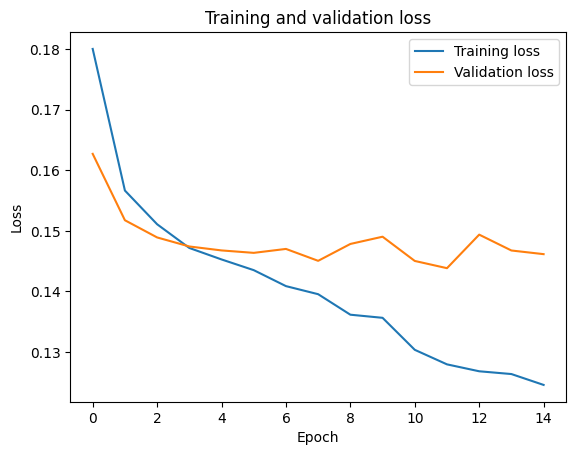

In [42]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
from keras.models import load_model
# Load the trained model
model1 = load_model('/kaggle/input/nih-chexefficentnetv2s/keras/default/1/EfficientNetV2S.keras')

In [44]:
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=labels,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=12022        
)

x_test, y_test = next(test_generator)

Found 12022 validated image filenames.


In [45]:
y_pred = model1.predict(x_test)

376/376 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step


In [46]:
# Get the true labels for the test data
#y_true = test_generator.labels
y_true= y_test
# Print the percentage of true and predicted diagnoses
for c_label, p_count, t_count in zip(labels, 
                                     100*np.mean(y_pred, 0), 
                                     100*np.mean(y_test, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: actual: 9.92%, predicted: 10.79%
Consolidation: actual: 3.82%, predicted: 4.84%
Infiltration: actual: 17.68%, predicted: 17.74%
Pneumothorax: actual: 5.76%, predicted: 5.30%
Edema: actual: 2.25%, predicted: 1.66%
Emphysema: actual: 2.19%, predicted: 3.01%
Fibrosis: actual: 1.46%, predicted: 1.68%
Effusion: actual: 11.90%, predicted: 14.25%
Pneumonia: actual: 1.20%, predicted: 0.97%
Pleural_Thickening: actual: 2.76%, predicted: 3.48%
Cardiomegaly: actual: 2.07%, predicted: 2.65%
Nodule: actual: 6.18%, predicted: 4.78%
Mass: actual: 5.54%, predicted: 5.06%
Hernia: actual: 0.20%, predicted: 0.20%


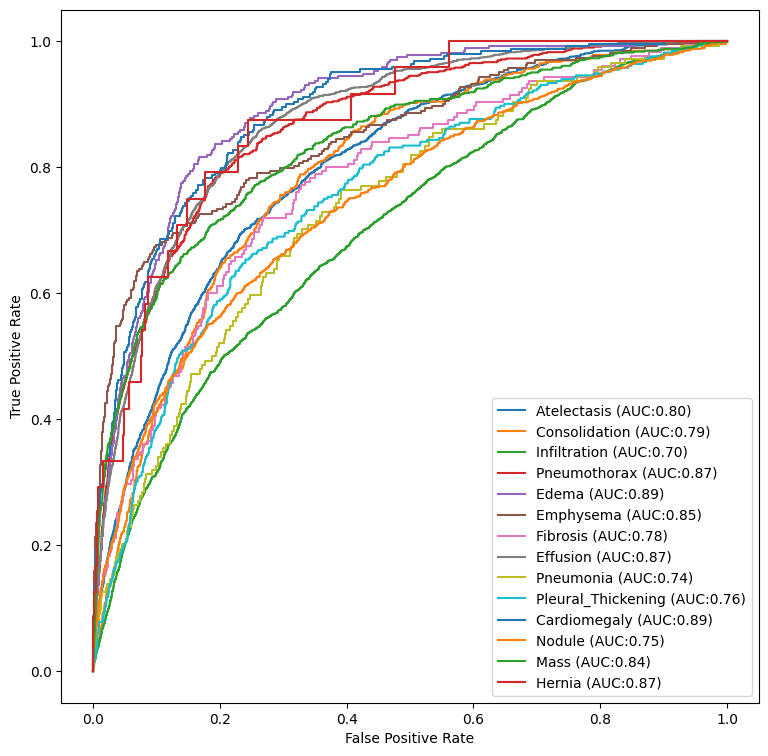

In [47]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('EfficientNetV2S_p3.png')

In [48]:
roc_auc_score(y_true.astype(int), y_pred)
# 0.806

0.8133752548217302

In [49]:
from sklearn.metrics import multilabel_confusion_matrix
# Convert the predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)

# Print the confusion matrix for each label
for i, label in enumerate(labels):
    print(f"Confusion matrix for {label}:")
    print(cm[i])

Confusion matrix for Atelectasis:
[[10808    22]
 [ 1141    51]]
Confusion matrix for Consolidation:
[[11563     0]
 [  459     0]]
Confusion matrix for Infiltration:
[[9776  121]
 [2009  116]]
Confusion matrix for Pneumothorax:
[[11288    42]
 [  631    61]]
Confusion matrix for Edema:
[[11751     0]
 [  271     0]]
Confusion matrix for Emphysema:
[[11713    46]
 [  207    56]]
Confusion matrix for Fibrosis:
[[11847     0]
 [  175     0]]
Confusion matrix for Effusion:
[[10082   509]
 [  830   601]]
Confusion matrix for Pneumonia:
[[11878     0]
 [  144     0]]
Confusion matrix for Pleural_Thickening:
[[11690     0]
 [  332     0]]
Confusion matrix for Cardiomegaly:
[[11742    31]
 [  225    24]]
Confusion matrix for Nodule:
[[11275     4]
 [  741     2]]
Confusion matrix for Mass:
[[11298    58]
 [  579    87]]
Confusion matrix for Hernia:
[[11998     0]
 [   24     0]]


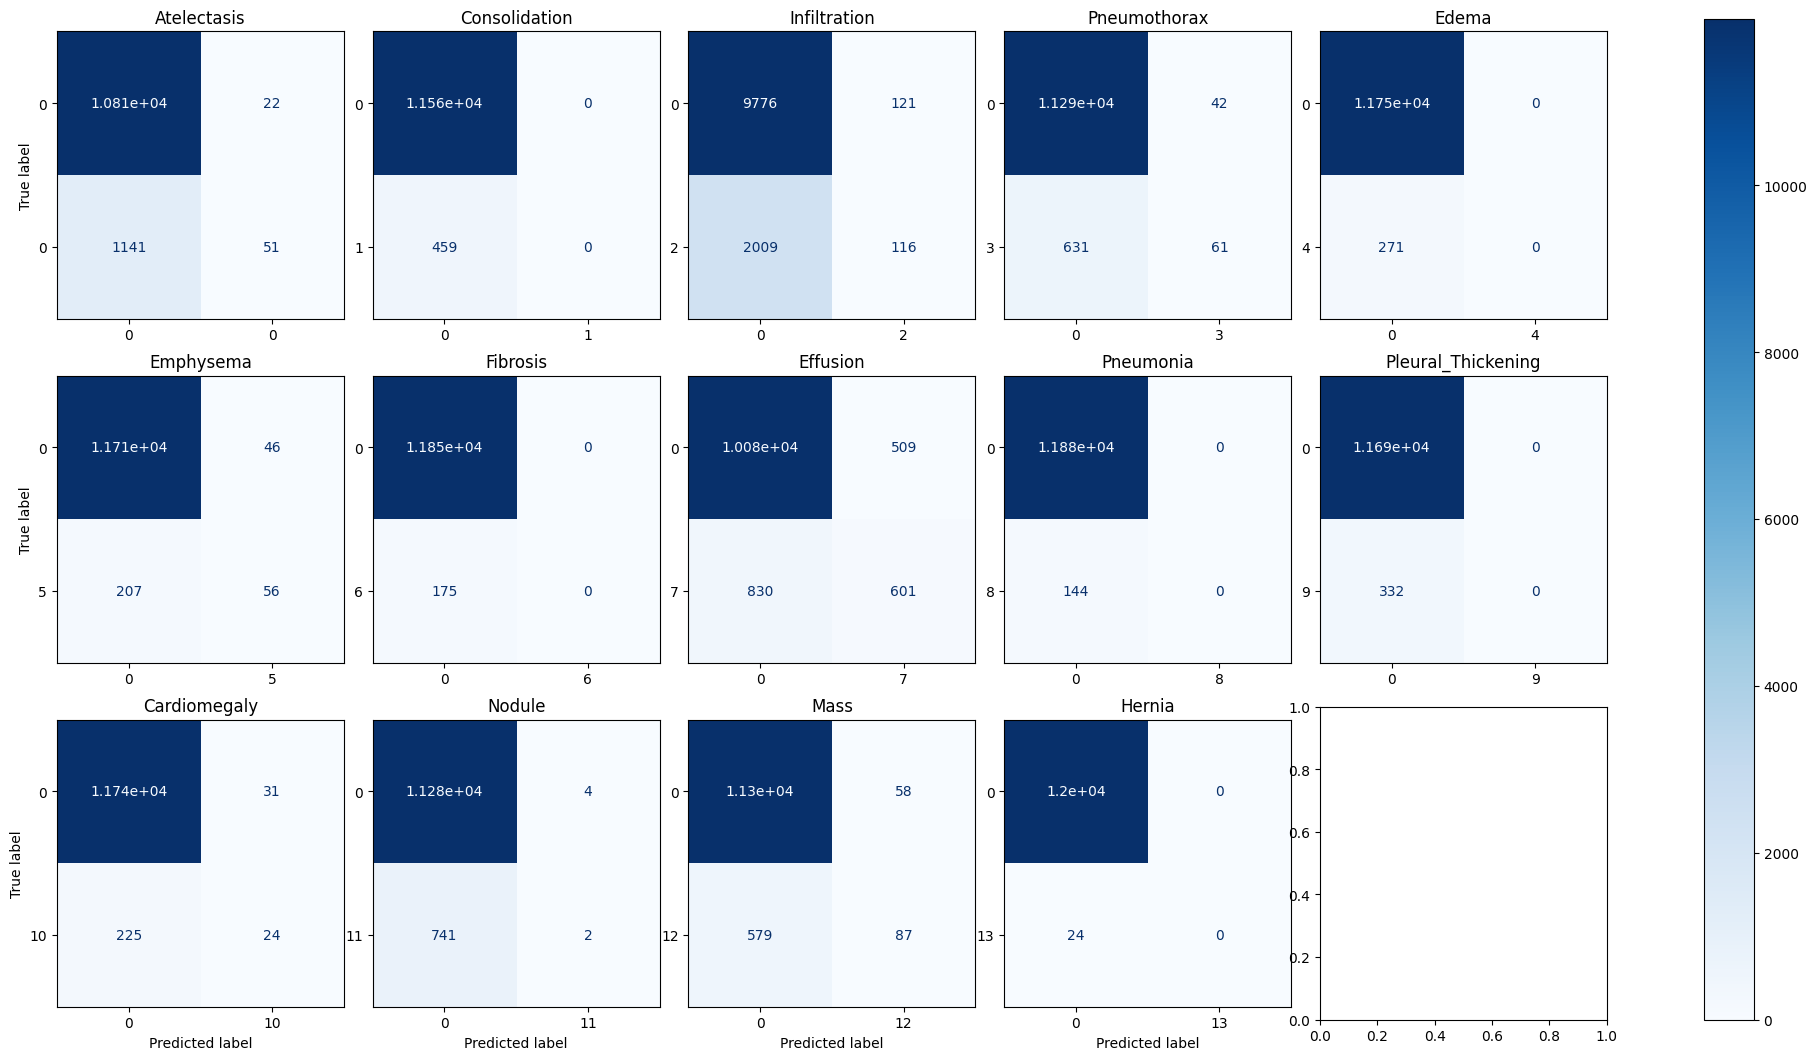

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
f, axes = plt.subplots(3, 5, figsize=(25, 13))
axes = axes.ravel()

# Loop through each class label
for i in range(len(labels)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, i])
    # Set the color map to 'Blues'
    disp.plot(ax=axes[i], values_format='.4g', cmap='Blues')
    disp.ax_.set_title(labels[i])
    if i < 10:
        disp.ax_.set_xlabel('')
    if i % 5 != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

# Adjust the spacing between the subplots and show the color bar
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)

# Show the plot
plt.show()

In [51]:
multi_gpu_model=0